In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import DataLoader, Dataset, Subset
import numpy as np
import matplotlib.pyplot as plt
import random
import math
from unet import Unet

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Device: ", device)
%matplotlib inline


Device:  cuda


In [2]:
'''
Dataset for training:
+ 2D Kolmogorov flow
+ 2D grids 256*256
+ 40 Trajectories
+ 320 Time steps per trajectory
+ The data is in "./Re1000_40Trajectory_320Step_256_256.npy"
+ The dimantionality of the numpy file is (40,320,256,256)
+ Reynolds number 1000
'''
class NumpyDataset(Dataset):
    def __init__(self, file_path):
        data = np.load(file_path)
        data = data[:-4]
        print(data.shape)
        print()
        # Reshape the data to create individual samples
        self.data = data.reshape(-1, 256, 256)
        # Normalize the data to [-1, 1]
        self.data = 2 * (self.data - np.min(self.data)) / (np.max(self.data) - np.min(self.data)) - 1

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image = self.data[idx]
        image = np.expand_dims(image, axis=0)  # Add channel dimension
        return torch.tensor(image, dtype=torch.float32)

# Load the full dataset
full_dataset = NumpyDataset("/home/baris/Documents/DDSim/Diffusion-based-Fluid-Super-resolution/data/kf_2d_re1000_256_40seed.npy")

# Select 10% of the dataset
percentage = 1
subset_size = int(percentage * len(full_dataset))
subset_indices = random.sample(range(len(full_dataset)), subset_size)
subset_dataset = Subset(full_dataset, subset_indices)

dataloader = DataLoader(subset_dataset, batch_size=27, shuffle=True)


(36, 320, 256, 256)



In [3]:
with_attention = True
model = Unet(with_attention).to(device)#SimpleUNet().to(device)


In [4]:
'''
Count the total number of parameters
'''
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'Total number of parameters: {count_parameters(model)}')


Total number of parameters: 2228673


In [ ]:
'''
Training
'''
def loss_fn(predicted_noise, true_noise):
    return ((predicted_noise - true_noise) ** 2).mean()

# Define a linear noise schedule
timesteps = 1000
betas = torch.linspace(1e-4, 0.02, timesteps).to(device)
alphas = 1 - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

optimizer = optim.Adam(model.parameters(), lr=2e-4, betas=(0.9, 0.999))
scheduler = lr_scheduler.StepLR(optimizer, step_size=20, gamma= 0.5)

#optimizer_state_dict = torch.load("unconditional_models/with_timestep_embedding/optimizer_epoch89.pth")
#scheduler_state_dict = torch.load("unconditional_models/with_timestep_embedding/lr_scheduler_epoch89.pth")
#optimizer.load_state_dict(optimizer_state_dict)
#scheduler.load_state_dict(scheduler_state_dict)
#
#state_dict = torch.load('unconditional_models/with_timestep_embedding/fixed_output_trained_model_epoch89.pth', map_location=torch.device('cpu'), weights_only=True)
#model.load_state_dict(state_dict)
model.to(device)

epochs = 500
losses = []

for epoch in range(epochs):
    epoch_losses = []
    for images in dataloader:
        images = images.to(device)

        # Randomly select a timestep
        t = torch.randint(0, timesteps, (images.size(0),), device=device).long()
        #t = random.randint(0, timesteps - 1)
        #nomalized_t = t / (timesteps)
        #time_step_channel = torch.ones_like(images) * nomalized_t
        #time_step_channel = time_step_channel.to(device)

        # Add noise according to the schedule
        noise = torch.randn_like(images)
        alpha_t_bar = alphas_cumprod[t].view(-1, 1, 1, 1)
        noisy_images = torch.sqrt(alpha_t_bar) * images + torch.sqrt(1 - alpha_t_bar) * noise
        
        #x_t_with_time_step = torch.cat((noisy_images, t), dim=1)

        optimizer.zero_grad()
        predicted_noise = model(noisy_images, t)
        loss = loss_fn(predicted_noise, noise)
        loss.backward()
        optimizer.step()

        epoch_losses.append(loss.item())

    average_loss = np.mean(epoch_losses)
    losses.append(average_loss)
    print(f"Epoch {epoch+1}/{epochs}, Loss: {average_loss}")
    if epoch % 100 == 0 and epoch > 0:
        torch.save(model.state_dict(), f'unconditional_models/with_timestep_embedding_new/fixed_output_trained_model_epoch{epoch}.pth')
    scheduler.step()
    
# Plot the loss after training
plt.figure(figsize=(10, 5))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


torch.save(model.state_dict(), 'unconditional_models/with_timestep_embedding_new/fixed_output_trained_model_epoch{epoch}.pth')

Epoch 1/500, Loss: 0.0936098740756756
Epoch 2/500, Loss: 0.0206125923334261
Epoch 3/500, Loss: 0.01555327114385206


In [22]:
torch.save(model.state_dict(), 'unconditional_models/with_attention/fixed_output_trained_model_epoch426.pth')
torch.save(scheduler.state_dict(), 'unconditional_models/with_attention/lr_scheduler_epoch426.pth')
torch.save(optimizer.state_dict(), 'unconditional_models/with_attention/optimizer_epoch426.pth')

In [4]:
'''
Reading the pretrained parameters
'''
model = Unet()
state_dict = torch.load('unconditional_models/with_attention/fixed_output_trained_model_epoch426.pth', map_location=torch.device('cpu'), weights_only=True)
model.load_state_dict(state_dict)
model.to(device)


Unet(
  (temb_layer0): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (temb_layer1): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=64, bias=True)
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (temb_layer2): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_

In [1]:
'''
Generating (inferencing) new samples
'''
def denoise(x_t, model, steps=1000):

    betas = torch.linspace(1e-4, 0.02, steps).to(device)
    alphas = 1 - betas
    alphas_cumprod = torch.cumprod(alphas, axis=0)

    for t in reversed(range(steps)):
        alpha_t_bar = alphas_cumprod[t]
        beta_t = betas[t]
        alpha_t = alphas[t]
        nomalized_t = t / (steps)
        time_step_channel = torch.ones_like(x_t) * nomalized_t
        time_step_channel = time_step_channel.to(device)
        x_t_with_time_step = torch.cat((x_t, time_step_channel), dim=1)
        t = torch.tensor(t, dtype=torch.float32, device=device).unsqueeze(0)
        # Predict the noise using the model
        with torch.no_grad():
            epsilon_theta = model(x_t, t)

        # Calculate the mean
        mean = (1 / torch.sqrt(alpha_t)) * (x_t - (beta_t / torch.sqrt(1 - alpha_t_bar)) * epsilon_theta)
        

        
        # Add noise for all but the last step
        if t > 0:
            z = torch.randn_like(x_t).to(device)
            x_t = mean + torch.sqrt(beta_t) * z
        else:
            x_t = mean

    return x_t

# Generate a sample noise image and denoise it
model.train()


sample_noise = torch.randn(1, 1, 256, 256).to(device)
generated_image = denoise(sample_noise, model)

plt.imshow(generated_image.squeeze().cpu())
plt.show()


NameError: name 'model' is not defined

In [21]:
print(model)

Unet(
  (temb_layer): Sequential(
    (0): Linear(in_features=32, out_features=128, bias=True)
    (1): ReLU()
    (2): Linear(in_features=128, out_features=128, bias=True)
  )
  (down1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (temb_proj1): Linear(in_features=128, out_features=64, bias=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
  )
  (temb_proj2): Linear(in_features=128, out_features=128, bias=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (middle): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(

(256, 256) (256, 256)
(1, 256, 256)
(1, 256)
(256, 256) (256, 256)
(1, 256, 256)
(1, 256)
(1, 256)


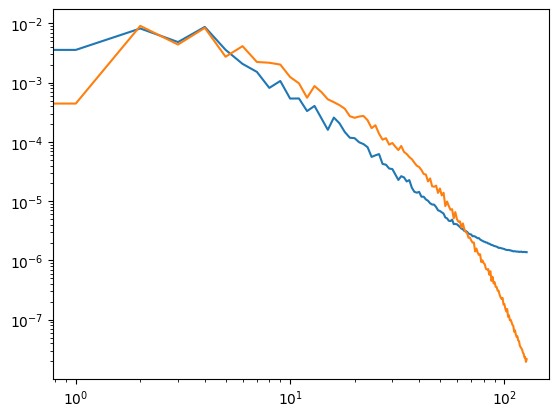

In [19]:
from energy_spectrum import compute_tke_spectrum
test_snapshot = subset_dataset[50]
_, wavenumbers, spectrum = compute_tke_spectrum(generated_image.detach().squeeze().cpu().numpy(),2 * np.pi,2 * np.pi)
_, wavenumbers, spectrum_gt = compute_tke_spectrum(test_snapshot.detach().squeeze().cpu().numpy(),2 * np.pi,2 * np.pi)

fig,ax = plt.subplots()

ax.set_xscale("log")
ax.set_yscale("log")
print(spectrum.shape)
ax.plot(wavenumbers[:128], spectrum[..., :128].T)
ax.plot(wavenumbers[:128], spectrum_gt[..., :128].T)